In [14]:
from pathlib import Path
import subprocess
import time
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def download_icloud(path):
    
    filename = path.name.split('.icloud')[0]
    filename = filename[1:]
    command = f'/usr/bin/brctl download {path}'
    subprocess.run(command.split())
    while not (path.parents[0]/filename).exists():
        time.sleep(0.25)

    return path.parents[0]/filename

def evict_icloud(path):
    
    filename = path.name
    filename = '.'+filename+'.icloud'
    command = f'/usr/bin/brctl evict {path}'
    subprocess.run(command.split())
    while (path.exists()):
        time.sleep(0.25)
    
    return path.parents[0]/filename
        

def collect_max_data():
    
    max_data = np.zeros((5, 31, 201))
    
    file_repository = Path.home()/'iCloud'/'penn_state_synca_data'/'beamforming'/'221216_beamforming_characterization'
    file_list = list(file_repository.glob('*.h5.icloud'))
    
    for i, file in enumerate(file_list):
        downloaded_file = download_icloud(file)
        file_name = downloaded_file.name

        r_ind = int(file_name.split('r')[-1].split('.h5')[0])
        z_ind = 2 + int(file_name.split('z')[-1].split('r')[0])//5
        
        h5file = h5py.File(downloaded_file, 'r')
        max_data[z_ind, r_ind, :] = h5file['max_data']['data'][:]
        
        h5file.close()
        evicted_file = evict_icloud(downloaded_file)
        
        if (i % 5) == 4:
            print(f'Progress = {round(100*(i+1)/len(file_list),1)}%')
        
    return max_data
        

def calculate_total_signal_power():
    
    total_power = np.zeros((5,31,201))
    file_repository = Path.home()/'iCloud'/'penn_state_synca_data'/'beamforming'/'221216_beamforming_characterization'
    file_list = list(file_repository.glob('*.h5.icloud'))
    
    for i, file in enumerate(file_list):
        downloaded_file = download_icloud(file)
        file_name = downloaded_file.name
        
        r_ind = int(file_name.split('r')[-1].split('.h5')[0])
        z_ind = 2 + int(file_name.split('z')[-1].split('r')[0])//5
        
        h5file = h5py.File(downloaded_file, 'r')
        array_data = h5file['array_data']['data'][:, :]

        temp = abs((array_data * np.exp(-1j * np.angle(array_data))).sum(axis=0))
        total_power[z_ind, r_ind, :] = temp
        
        h5file.close()
        evicted_file = evict_icloud(downloaded_file)
        
        if (i % 5) == 4:
            print(f'Progress = {round(100*(i+1)/len(file_list),1)}%')
            
    return total_power
        

In [5]:
file_repository = Path.home()/'iCloud'/'penn_state_synca_data'/'beamforming'/'221216_beamforming_characterization'
file_list = list(file_repository.glob('*.h5.icloud'))

In [7]:
test_file = download_icloud(file_list[0])

In [8]:
test_h5 = h5py.File(test_file, 'r')

In [9]:
print(test_h5.keys())

<KeysViewHDF5 ['array_data', 'image_data', 'max_data', 'meta', 'summed_array_data']>


In [10]:
test_h5['image_data']['data'].shape

(81, 81, 201)

In [11]:
test_h5['array_data']['data'].shape

(120, 201)

In [12]:
test_h5.close()

In [13]:
evict_icloud(test_file)

PosixPath('/Users/ziegler/iCloud/penn_state_synca_data/beamforming/221216_beamforming_characterization/.z10r3.h5.icloud')

In [17]:
max_data = collect_max_data()

Progress = 3.2%
Progress = 6.5%
Progress = 9.7%
Progress = 12.9%
Progress = 16.1%
Progress = 19.4%
Progress = 22.6%
Progress = 25.8%
Progress = 29.0%
Progress = 32.3%
Progress = 35.5%
Progress = 38.7%
Progress = 41.9%
Progress = 45.2%
Progress = 48.4%
Progress = 51.6%
Progress = 54.8%
Progress = 58.1%
Progress = 61.3%
Progress = 64.5%
Progress = 67.7%
Progress = 71.0%
Progress = 74.2%
Progress = 77.4%
Progress = 80.6%
Progress = 83.9%
Progress = 87.1%
Progress = 90.3%
Progress = 93.5%
Progress = 96.8%
Progress = 100.0%


In [18]:
tot_pow_data = calculate_total_signal_power()

Progress = 3.2%
Progress = 6.5%
Progress = 9.7%
Progress = 12.9%
Progress = 16.1%
Progress = 19.4%
Progress = 22.6%
Progress = 25.8%
Progress = 29.0%
Progress = 32.3%
Progress = 35.5%
Progress = 38.7%
Progress = 41.9%
Progress = 45.2%
Progress = 48.4%
Progress = 51.6%
Progress = 54.8%
Progress = 58.1%
Progress = 61.3%
Progress = 64.5%
Progress = 67.7%
Progress = 71.0%
Progress = 74.2%
Progress = 77.4%
Progress = 80.6%
Progress = 83.9%
Progress = 87.1%
Progress = 90.3%
Progress = 93.5%
Progress = 96.8%
Progress = 100.0%


In [19]:
max_data.shape

(5, 31, 201)

In [43]:
tot_pow_data.shape

(5, 31, 201)

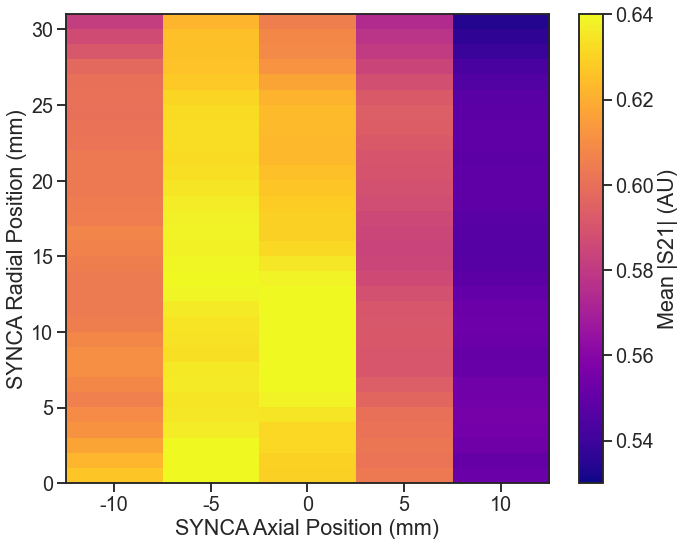

In [42]:
sns.set_theme(style='ticks', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)


img = ax.imshow(
    np.flip(max_data.mean(axis=-1), axis=1).T,
    cmap = 'plasma',
    aspect='auto',
    extent=(-15, 15, 0, 31),
    vmin=0.53,
    vmax=0.64
    
)
ax.set_xticks([-12, -6, 0., 6., 12])
ax.set_xticklabels([-10, -5, 0, 5, 10])
fig.colorbar(img, label='Mean |S21| (AU)')
ax.set_ylabel('SYNCA Radial Position (mm)')
ax.set_xlabel('SYNCA Axial Position (mm)')

plt.tight_layout(pad=1.02)
plt.savefig(Path.home()/'iCloud'/'plots'/'221230_penn_state_mean_beamforming_map', dpi=128)

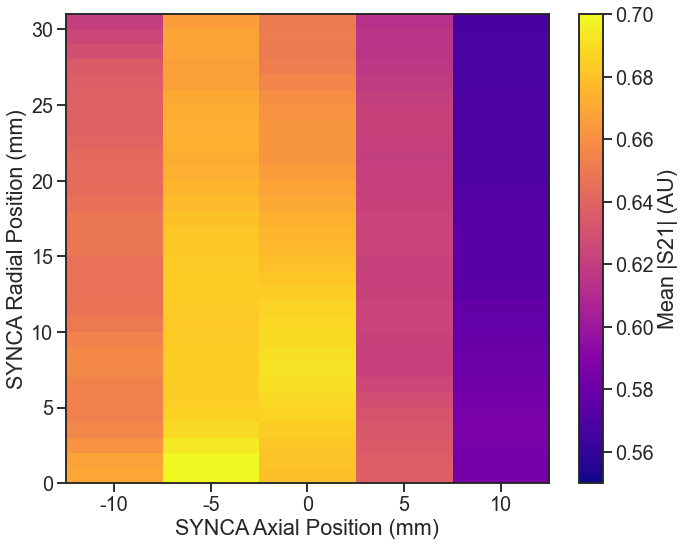

In [51]:
sns.set_theme(style='ticks', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)


img = ax.imshow(
    np.flip(tot_pow_data.mean(axis=-1), axis=1).T,
    cmap = 'plasma',
    aspect='auto',
    extent=(-15, 15, 0, 31),
    vmin=0.55,
    vmax=0.7
    
)
ax.set_xticks([-12, -6, 0., 6., 12])
ax.set_xticklabels([-10, -5, 0, 5, 10])
fig.colorbar(img, label='Mean |S21| (AU)')
ax.set_ylabel('SYNCA Radial Position (mm)')
ax.set_xlabel('SYNCA Axial Position (mm)')

plt.tight_layout(pad=1.02)
plt.savefig(Path.home()/'iCloud'/'plots'/'221230_penn_state_mean_total_power_map', dpi=128)

# Mean Beamformed Power

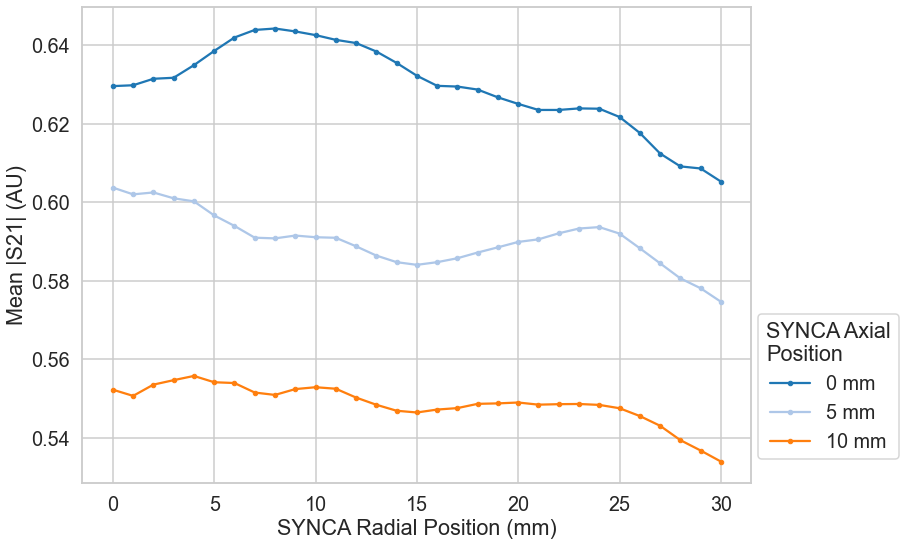

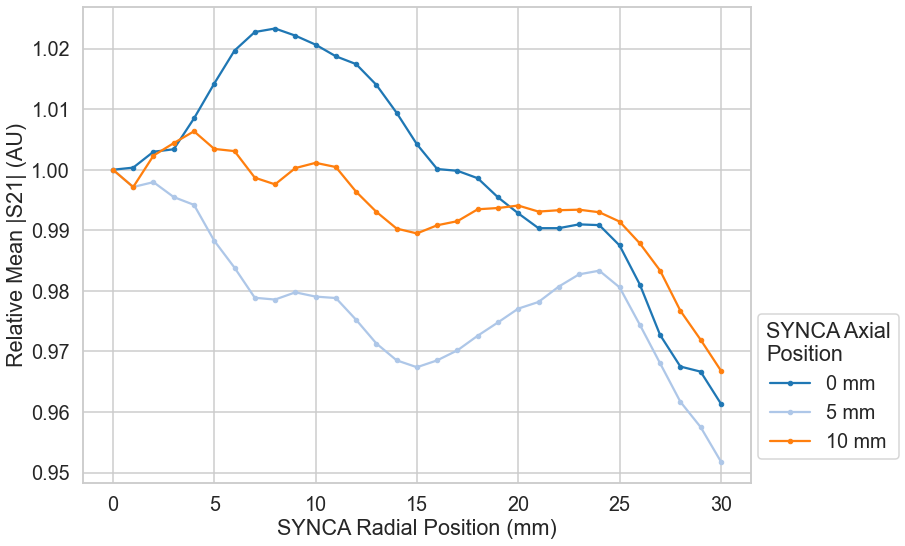

In [58]:
max_data_mean = max_data.mean(axis=-1)

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

clist = sns.color_palette('tab20', n_colors=11)

for i in range(3):
    ax.plot(np.arange(0, 31, 1)* 1, max_data_mean[i+2, :], '.-', color=clist[i], label=f'{5*i} mm')

ax.set_xlabel('SYNCA Radial Position (mm)')
ax.set_ylabel(r'Mean |S21| (AU)')
#ax.set_ylim(0.3, 0.66)

ax.legend(loc=(1.01, 0.05), title='SYNCA Axial'+'\n'+'Position')
plt.tight_layout(pad=1.02)
#plt.savefig(Path.home()/'iCloud'/'plots'/'221213_jugaad_mean_beamformed_power_curves')

##########

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

clist = sns.color_palette('tab20', n_colors=11)

for i in range(3):
    ax.plot(np.arange(0, 31, 1)* 1, max_data_mean[i+2, :]/max_data_mean[i+2,0], '.-', color=clist[i], label=f'{5*i} mm')

ax.set_xlabel('SYNCA Radial Position (mm)')
ax.set_ylabel(r'Relative Mean |S21| (AU)')

ax.legend(loc=(1.01, 0.05), title='SYNCA Axial'+'\n'+'Position')
plt.tight_layout(pad=1.02)
#plt.savefig(Path.home()/'iCloud'/'plots'/'221213_jugaad_mean_beamformed_power_curves_relative')

##########

#sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
#fig = plt.figure(figsize=(13, 8))
#ax = fig.add_subplot(1,1,1)

#clist = sns.color_palette('tab20', n_colors=11)

#for i in range(3):
#    ax.plot(np.arange(0, 31, 1)* 1, max_data_mean[i+2, :]/max_data_mean[i+2,0], '.-', color=clist[i], label=f'{5*i} mm')

#ax.set_xlabel('SYNCA Radial Position (mm)')
#ax.set_ylabel(r'Relative Mean |S21| (AU)')

#ax.legend(loc=(1.01, 0.05), title='SYNCA Axial'+'\n'+'Position')
#plt.tight_layout(pad=1.02)
#plt.savefig(Path.home()/'iCloud'/'plots'/'221213_jugaad_mean_beamformed_power_curves_relative_restricted')